Neural Networks have become very trendy nowadays, in part because of their superior performance on image recognition related tasks. Take for instance the [Deep Visual-Semantic Alignments](http://cs.stanford.edu/people/karpathy/deepimagesent/) network from Stanford, which is able to generate sentence descriptions from images and achieve other amazing results. But this power comes at a cost, as most of these models are trained with thousands (or millions) of inputs, and require the expensive computational cost of GPU's. Sometimes, if our image-classification task is a simpler one, we can get away with much simpler approaches.

This is exactly what I'll do in this post: I'll use the **PCA** dimensionality reduction and the traditional **kNN** to build a classifier that can distinguish between two type of images: french impressionist and photographic landscapes.

In [1]:
## Load libraries.
from bs4 import BeautifulSoup
import urllib
import json
from tqdm import tqdm
import os
import re

### The Dataset
I'll get both set of images from *allposters.com* using Beautiful Soup, and I'll aim to get just ~150 images for each category to avoid annoying them when hitting their server. The target searches are *French Impressionism Posters* (most of them which are landscapes) and *Landscapes Photography Posters*.

In [2]:
## Read galleries and collect items.
url = 'http://www.allposters.com/-st/French-Impressionism-Posters_c12678_'
pages = ['', 'p2_', 'p3_', 'p4_', 'p5_']
directory = 'impressionist/'

print 'Getting impressionist landscapes...'

for page in pages:
    r = urllib.urlopen(url + page +  '.htm').read()
    soup = BeautifulSoup(r, 'html.parser')

    ## Gather links.
    links = soup.find_all('a', {'href' : re.compile('sp')})
    filtered = [link['href'] for link in links if link.find('img', {'class':'thmbd galImage'})]
    
    ## Visit links to download main images.
    for link in filtered:
        r = urllib.urlopen('http://www.allposters.com/' + link).read()
        soup = BeautifulSoup(r, 'html.parser')
        img_link = soup.find('img', {'class': 'mainImage shadow'})['src']
        img_name = directory + re.split('/', img_link)[-1]
        if not os.path.exists(img_name):
            urllib.urlretrieve(img_link, img_name)
            
print 'Done!'

Getting impressionist landscapes...
Done!


In [3]:
## Read galleries and collect items.
url = 'http://www.allposters.com/-st/Landscapes-Photography-Posters_c624_'
pages = ['', 'p2_', 'p3_', 'p4_', 'p5_']
directory = 'photographs/'

print 'Getting photographic landscapes...'

for page in pages:
    r = urllib.urlopen(url + page +  '.htm').read()
    soup = BeautifulSoup(r, 'html.parser')

    ## Gather links.
    links = soup.find_all('a', {'href' : re.compile('sp')})
    filtered = [link['href'] for link in links if link.find('img', {'class':'thmbd galImage'})]
    
    ## Visit links to download main images.
    for link in filtered:
        r = urllib.urlopen('http://www.allposters.com/' + link).read()
        soup = BeautifulSoup(r, 'html.parser')
        img_link = soup.find('img', {'class': 'mainImage shadow'})['src']
        img_name = directory + re.split('/', img_link)[-1]
        if not os.path.exists(img_name):
            urllib.urlretrieve(img_link, img_name)
            
print 'Done!'

Getting photographic landscapes...
Done!


In [4]:
## Loading next set of libraries...
import os
import numpy as np
import pandas as pd
from libs import utils
import matplotlib.pyplot as plt
from skimage.transform import resize
import seaborn as sns
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style('white')

Below is are two sample montages of both categories. I've cropped and resized all of them to 150x150 so we can compare on a pixel-by-pixel basis. I've also arranged them in a 4D matrix with dimensions `I x W x H x C`, which represent the image number, width, height and RGB channel, respectively. For us this represents a picture, while to the classifier this is just a matrix of numeric features.

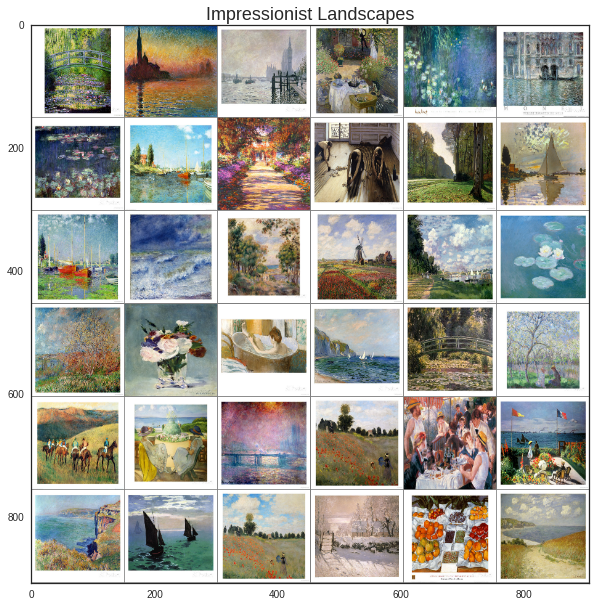

In [5]:
dirname = 'impressionist'
fileset1 = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]

## Read every filename as RGB.
impressionists = [plt.imread(fname)for fname in fileset1]

## Crop to squares.
impressionists = [utils.imcrop_tosquare(img_i) for img_i in impressionists]

## Resize to 150 x 150 px.
impressionists = [resize(img_i, (150, 150)) for img_i in impressionists]

## Convert 3-D images into a 4-D array.
## Last dimension the number of images.
impressionists = np.array(impressionists).astype(np.float32)

## Plot a montage of our images.
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(impressionists[:36]))
plt.title('Impressionist Landscapes', size=18);

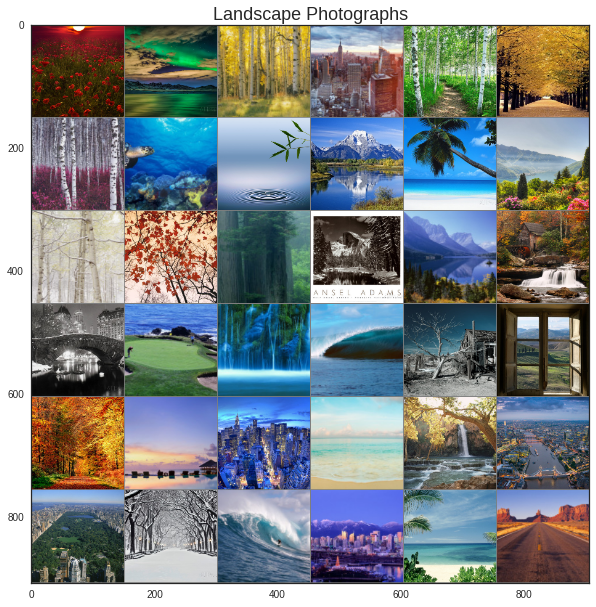

In [6]:
dirname = 'photographs'
fileset2 = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]

photographs = [plt.imread(fname)for fname in fileset2]

photographs = [utils.imcrop_tosquare(img_i) for img_i in photographs]

photographs = [resize(img_i, (150, 150)) for img_i in photographs]

photographs = np.array(photographs).astype(np.float32)

plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(photographs[:36]))
plt.title('Landscape Photographs', size=18);

### The Model

Now the interesting part: training the classifier to distinguish between the 2 categories. Each of the images is represented by a vector of `150*150*3=67500` features, representing the total pixels on each of the channel colors. This seems like a bit too much... maybe with a dimensionality reduction technique we can compress the data into just a couple of feats.

#### PCA
PCA, a technique that makes linear combination of features to come up with a subset of them that explains most of the variance, can help us with this. StackOverflow has a [very nice and clear](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) post explaining the intuition behind it, but I think this image sums it up pretty well; of you look at both the errors (red lines) and projections (red dots), you'll notice that when the linear combination is equal to the pink line, the variance on the projection is the largest and the sum of errors is minimized, which is precisely what we want.

![visual representation of PCA](/images/pca.gif "PCA")

So, we use PCA to reduce the dimensionality of the data from 675,000 features to the 5 most important linear combinations of them. For illustrative purposes, below I present the first two ones, where we can already see that each set has unique characteristics (i.e. impressionists tend to be more 'to the left'). A classifier with only these 2 dimensions will still make many mistakes, so adding a couple of extra ones should improve the performance (hence 5).

In [7]:
from sklearn.cross_validation import train_test_split

## Flatten feature space.
data = [img.ravel() for img in impressionists] + [img.ravel() for img in photographs]
labels = ['impressionists'] * len(impressionists) + ['photographs'] * len(photographs)
names = fileset1 + fileset2

## Divide into training and test.
train_X, test_X, train_y, test_y, train_n, test_n = train_test_split(data, labels, names, test_size=0.2)

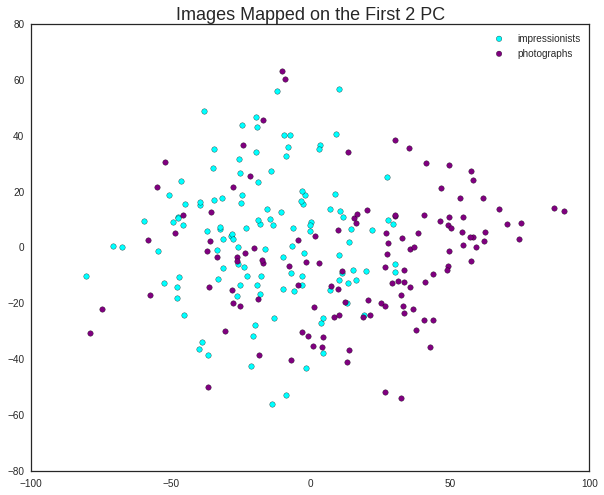

In [8]:
from sklearn.decomposition import PCA

## Reduce to 2 dimensions.
pca = PCA(n_components=2)
X = pca.fit_transform(train_X)

df = pd.DataFrame({'x0': X[:, 0], 'x1': X[:, 1], "label":train_y})
colors = ["aqua", "purple"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['x0'], df[mask]['x1'], c=color, s=30, label=label)
plt.legend()
plt.title('Images Mapped on the First 2 PC', size=18);

#### kNN
Now that the data is reduced, we need to settle for a classifier. I think kNN is a good candidate, as a visual inspection of the plot above suggests that determining the class of an image as that of the majority of its neighbors is not such a bad idea. This is one of the simplest models available, and is also cheap to compute since it doesn't actually estimate any parameters. The number of nearest neighbors to consider will be *k=5*. 

In [9]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(n_components=5)
train_pca = pca.fit_transform(train_X)
test_pca = pca.transform(test_X)
knn = KNeighborsClassifier()
knn.fit(train_pca, train_y)

## Distribution of test cases.
print {n: float(test_y.count(n))/float(len(test_y))*100 for n in test_y}

{'photographs': 50.0, 'impressionists': 50.0}


Now its time to test the results, on a separate hidden test dataset. A classifier that predicts 'impressionist' all the time would have 50% accuracy, so hopefully we should do better than that...

## Results

In [10]:
print 'Accuracy rate on test dataset is %.2f%%.' %(knn.score(test_pca, test_y)*100)

Accuracy rate on test dataset is 88.71%.


Not bat at all! Only 7 images were not classified correctly. Let's take a look at them:

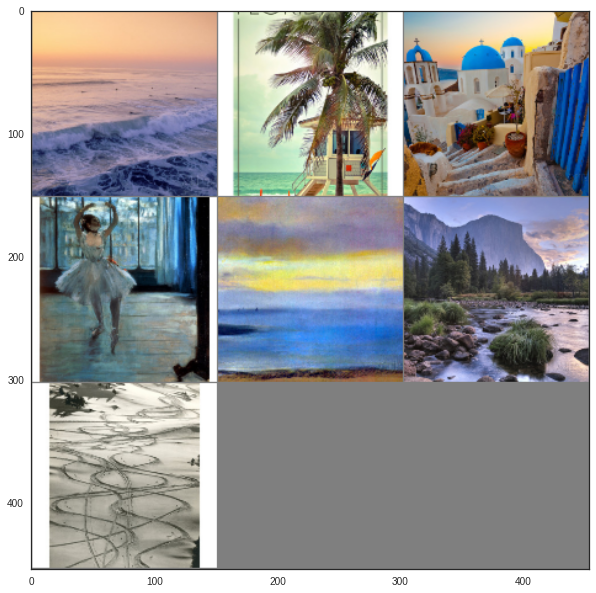

In [11]:
from itertools import compress
correct = knn.predict(test_pca) == test_y
missed = list(compress(test_n, ~correct))


incorrect = [plt.imread(fname)for fname in missed]

incorrect = [utils.imcrop_tosquare(img_i) for img_i in incorrect]

incorrect = [resize(img_i, (150, 150)) for img_i in incorrect]

incorrect = np.array(incorrect).astype(np.float32)

plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(incorrect));

Well, even I have some trouble classifying each of them, so these examples asides, this simple classifier is doing an excelent job. We could improve the performance via cross-validation to pick up the best hyperparameters, such as the value of *k* and the distance matrix. But for now I'm glad with the results so I'll leave the model as-is.